## Dataset Understanding

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#import the dataset
iris = pd.read_csv("Iris.csv")
#Let's have a look at the dataset
iris.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


So we have Species of Iris Flower and their Sepal Length, Sepal Width, Petal Length, Petal Width is given as the features.

In [3]:
print(iris.columns)

Index(['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm',
       'Species'],
      dtype='object')


In [4]:
# Q : How many data point and features?
print(iris.shape) ##rows and columns

(150, 6)


In [25]:
#Let's remove the id column.
iris.drop('Id', axis= 1, inplace= True)

#(Q) How many data points for each class are present?
print(iris['Species'].value_counts())

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: Species, dtype: int64


## ML Model

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

spliting dataset into features and target.

features=SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm

Target=Species

In [4]:
X= iris.iloc[:, 0:4] ##predictors
y= iris.iloc[:, 4] ##response variable

Converting Categorical to Numbers.

In [29]:
# Giving Numerical values to our class labels as we will have to convert them to pytorch tensors.

for i in range(len(y)):
    if y[i] == 'Iris-setosa':
        y[i] = 0
    elif y[i] == 'Iris-versicolor':
        y[i] = 1
    else:
        y[i] = 2


/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Normalizing the X, so our gradient steps converge fast

In [30]:
from sklearn.preprocessing import normalize
X = normalize(X) ##x-mean/std
y = np.array(y)
y = y.astype(int)



Spliting data into Train and test parts.

In [31]:
X_train,X_test,y_train,y_test= train_test_split(X, y, test_size= 0.10, random_state= 1)
print ('X_train shape: ',X_train.shape)
print ('y_train shape: ',y_train.shape)
print ('X_test shape: ',X_test.shape)
print ('y_test shape: ',y_test.shape)

X_train shape:  (135, 4)
y_train shape:  (135,)
X_test shape:  (15, 4)
y_test shape:  (15,)


In [32]:
from torch import optim
import torch
import torch.nn as nn

Making NN for Our Problem, with 2 hidden layers and one output layer. The architecture of neural network look like this 

    Input layer: 4 Neurons
    1st Hidden layer: 27 Neurons
    2nd Hidden layer: 9 Neurons
    Output Layer: 3 Neurons

![Architecture](Capture.JPG)



We use Log NLLLoss, negative log likelihood loss. It is useful to train a classification problem with number of classes classes. we use SGD, Stochastic gradient descent optimization method to update the weights. 

In [33]:
model = nn.Sequential(nn.Linear(4, 27), ##4 predictors
                      nn.ReLU(),
                      nn.Linear(27,9), ##hidden layers
                      nn.ReLU(),
                      nn.Linear(9,3), ##3 output classes
                      nn.LogSoftmax(dim= 1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [34]:
print(model) # model summary

Sequential(
  (0): Linear(in_features=4, out_features=27, bias=True)
  (1): ReLU()
  (2): Linear(in_features=27, out_features=9, bias=True)
  (3): ReLU()
  (4): Linear(in_features=9, out_features=3, bias=True)
  (5): LogSoftmax()
)


predict function that take input and then return the predicted class

In [35]:
def predict(model, inputs):
    output = model(inputs)
    return output.data.numpy().argmax(axis= 1)

In [36]:
# making torch tensors base data that can be used for training. 
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).long() 

In [37]:
epochs= 1000
batch_size= 15
n_batches = 9

costs = []
test_accuracies = []
for e in range(epochs):
    running_loss = 0
    for j in range(n_batches):
        ## taking a batch of data for training, taking only 15 entries for training at one time.
        Xbatch = X_train[j*batch_size:(j+1)*batch_size]
        Ybatch = y_train[j*batch_size:(j+1)*batch_size]
        
        ##---------------------------------------##
        #In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch
        optimizer.zero_grad() # accumulates the gradients on subsequent backward passes.
        output = model(Xbatch)#forward propagation
        loss = criterion(output, Ybatch)# calculating the loss
        loss.backward()# performing backward propagation
        optimizer.step()# updating the weight
        running_loss += loss.item()# finding the loss during this step.
        ##---------------------------------------##
        
        
    Ypred = predict(model, X_test)
    
    acc = np.mean(y_test == Ypred)
    
    print("Epoch: %d, cost: %f, accuracy: %.2f" % (e, running_loss/n_batches, acc))
    
    costs.append(running_loss/n_batches)
    test_accuracies.append(acc)

Epoch: 0, cost: 1.106114, accuracy: 0.40
Epoch: 1, cost: 1.105823, accuracy: 0.40
Epoch: 2, cost: 1.105545, accuracy: 0.40
Epoch: 3, cost: 1.105273, accuracy: 0.40
Epoch: 4, cost: 1.105007, accuracy: 0.40
Epoch: 5, cost: 1.104744, accuracy: 0.40
Epoch: 6, cost: 1.104485, accuracy: 0.40
Epoch: 7, cost: 1.104228, accuracy: 0.40
Epoch: 8, cost: 1.103974, accuracy: 0.40
Epoch: 9, cost: 1.103722, accuracy: 0.40
Epoch: 10, cost: 1.103473, accuracy: 0.40
Epoch: 11, cost: 1.103226, accuracy: 0.40
Epoch: 12, cost: 1.102984, accuracy: 0.40
Epoch: 13, cost: 1.102745, accuracy: 0.40
Epoch: 14, cost: 1.102509, accuracy: 0.40
Epoch: 15, cost: 1.102275, accuracy: 0.40
Epoch: 16, cost: 1.102043, accuracy: 0.40
Epoch: 17, cost: 1.101813, accuracy: 0.40
Epoch: 18, cost: 1.101586, accuracy: 0.40
Epoch: 19, cost: 1.101361, accuracy: 0.40
Epoch: 20, cost: 1.101138, accuracy: 0.40
Epoch: 21, cost: 1.100917, accuracy: 0.40
Epoch: 22, cost: 1.100697, accuracy: 0.40
Epoch: 23, cost: 1.100479, accuracy: 0.40
Ep

Epoch: 199, cost: 1.064844, accuracy: 0.60
Epoch: 200, cost: 1.064524, accuracy: 0.60
Epoch: 201, cost: 1.064200, accuracy: 0.60
Epoch: 202, cost: 1.063873, accuracy: 0.60
Epoch: 203, cost: 1.063542, accuracy: 0.60
Epoch: 204, cost: 1.063213, accuracy: 0.60
Epoch: 205, cost: 1.062880, accuracy: 0.60
Epoch: 206, cost: 1.062541, accuracy: 0.60
Epoch: 207, cost: 1.062205, accuracy: 0.60
Epoch: 208, cost: 1.061863, accuracy: 0.60
Epoch: 209, cost: 1.061518, accuracy: 0.60
Epoch: 210, cost: 1.061168, accuracy: 0.60
Epoch: 211, cost: 1.060820, accuracy: 0.60
Epoch: 212, cost: 1.060466, accuracy: 0.60
Epoch: 213, cost: 1.060106, accuracy: 0.60
Epoch: 214, cost: 1.059749, accuracy: 0.60
Epoch: 215, cost: 1.059383, accuracy: 0.60
Epoch: 216, cost: 1.059018, accuracy: 0.60
Epoch: 217, cost: 1.058649, accuracy: 0.60
Epoch: 218, cost: 1.058273, accuracy: 0.60
Epoch: 219, cost: 1.057899, accuracy: 0.60
Epoch: 220, cost: 1.057516, accuracy: 0.60
Epoch: 221, cost: 1.057135, accuracy: 0.60
Epoch: 222,

Epoch: 398, cost: 0.901073, accuracy: 0.60
Epoch: 399, cost: 0.899564, accuracy: 0.60
Epoch: 400, cost: 0.898048, accuracy: 0.60
Epoch: 401, cost: 0.896526, accuracy: 0.60
Epoch: 402, cost: 0.894996, accuracy: 0.60
Epoch: 403, cost: 0.893460, accuracy: 0.60
Epoch: 404, cost: 0.891917, accuracy: 0.60
Epoch: 405, cost: 0.890369, accuracy: 0.60
Epoch: 406, cost: 0.888813, accuracy: 0.60
Epoch: 407, cost: 0.887251, accuracy: 0.60
Epoch: 408, cost: 0.885681, accuracy: 0.60
Epoch: 409, cost: 0.884107, accuracy: 0.60
Epoch: 410, cost: 0.882526, accuracy: 0.60
Epoch: 411, cost: 0.880940, accuracy: 0.60
Epoch: 412, cost: 0.879347, accuracy: 0.60
Epoch: 413, cost: 0.877748, accuracy: 0.60
Epoch: 414, cost: 0.876143, accuracy: 0.60
Epoch: 415, cost: 0.874532, accuracy: 0.60
Epoch: 416, cost: 0.872914, accuracy: 0.60
Epoch: 417, cost: 0.871291, accuracy: 0.60
Epoch: 418, cost: 0.869661, accuracy: 0.60
Epoch: 419, cost: 0.868025, accuracy: 0.60
Epoch: 420, cost: 0.866386, accuracy: 0.60
Epoch: 421,

Epoch: 599, cost: 0.587826, accuracy: 0.67
Epoch: 600, cost: 0.586741, accuracy: 0.67
Epoch: 601, cost: 0.585661, accuracy: 0.67
Epoch: 602, cost: 0.584586, accuracy: 0.67
Epoch: 603, cost: 0.583517, accuracy: 0.67
Epoch: 604, cost: 0.582455, accuracy: 0.67
Epoch: 605, cost: 0.581397, accuracy: 0.67
Epoch: 606, cost: 0.580345, accuracy: 0.67
Epoch: 607, cost: 0.579299, accuracy: 0.67
Epoch: 608, cost: 0.578257, accuracy: 0.67
Epoch: 609, cost: 0.577221, accuracy: 0.73
Epoch: 610, cost: 0.576190, accuracy: 0.73
Epoch: 611, cost: 0.575164, accuracy: 0.73
Epoch: 612, cost: 0.574143, accuracy: 0.73
Epoch: 613, cost: 0.573127, accuracy: 0.73
Epoch: 614, cost: 0.572115, accuracy: 0.73
Epoch: 615, cost: 0.571109, accuracy: 0.73
Epoch: 616, cost: 0.570108, accuracy: 0.73
Epoch: 617, cost: 0.569112, accuracy: 0.73
Epoch: 618, cost: 0.568118, accuracy: 0.73
Epoch: 619, cost: 0.567136, accuracy: 0.73
Epoch: 620, cost: 0.566152, accuracy: 0.73
Epoch: 621, cost: 0.565177, accuracy: 0.73
Epoch: 622,

Epoch: 824, cost: 0.430850, accuracy: 1.00
Epoch: 825, cost: 0.430351, accuracy: 1.00
Epoch: 826, cost: 0.429864, accuracy: 1.00
Epoch: 827, cost: 0.429357, accuracy: 1.00
Epoch: 828, cost: 0.428860, accuracy: 1.00
Epoch: 829, cost: 0.428364, accuracy: 1.00
Epoch: 830, cost: 0.427868, accuracy: 1.00
Epoch: 831, cost: 0.427373, accuracy: 1.00
Epoch: 832, cost: 0.426877, accuracy: 1.00
Epoch: 833, cost: 0.426383, accuracy: 1.00
Epoch: 834, cost: 0.425893, accuracy: 1.00
Epoch: 835, cost: 0.425402, accuracy: 1.00
Epoch: 836, cost: 0.424910, accuracy: 1.00
Epoch: 837, cost: 0.424420, accuracy: 1.00
Epoch: 838, cost: 0.423929, accuracy: 1.00
Epoch: 839, cost: 0.423439, accuracy: 1.00
Epoch: 840, cost: 0.422949, accuracy: 1.00
Epoch: 841, cost: 0.422459, accuracy: 1.00
Epoch: 842, cost: 0.421970, accuracy: 1.00
Epoch: 843, cost: 0.421480, accuracy: 1.00
Epoch: 844, cost: 0.420991, accuracy: 1.00
Epoch: 845, cost: 0.420497, accuracy: 1.00
Epoch: 846, cost: 0.420015, accuracy: 1.00
Epoch: 847,

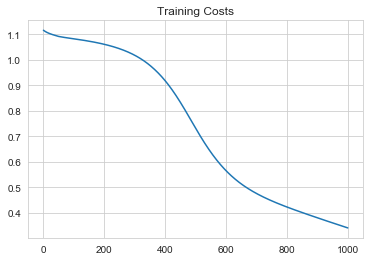

In [30]:
%matplotlib inline
plt.plot(costs)
plt.title("Training Costs")
plt.show()

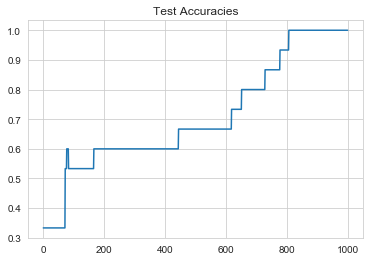

In [31]:
plt.plot(test_accuracies)
plt.title("Test Accuracies")
plt.show()

In [32]:
from sklearn.metrics import accuracy_score
ypred = predict(model, X_test)

print("Accuracy Score is {}".format(accuracy_score(y_test, ypred)))

Accuracy Score is 1.0
